In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 18})
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
%matplotlib widget


In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid
    
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def binning_data(array1,array2,delt):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    plt.figure(figsize=(10,6))
    plt.scatter(levels_centres,binned_data)

def binning_data_hist2D(array1,array2,delt):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
    plt.figure(figsize=(10,6))
    plt.hist2d(levels_centres,binned_data,bins=[levels,binned_data_bins])

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param

def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil


Filename: ../FITS_file/CygX_E_OTFMAP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1095   (110, 93)   float64   
  1  ERROR I       1 ImageHDU        19   (110, 93)   float64   
  2  STOKES Q      1 ImageHDU        19   (110, 93)   float64   
  3  ERROR Q       1 ImageHDU        19   (110, 93)   float64   
  4  STOKES U      1 ImageHDU        19   (110, 93)   float64   
  5  ERROR U       1 ImageHDU        19   (110, 93)   float64   
  6  IMAGE MASK    1 ImageHDU        35   (110, 93)   float64   
  7  PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
 10  POL ANGLE     1 ImageHDU        19   (110, 93)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 13  POL FLUX      1 

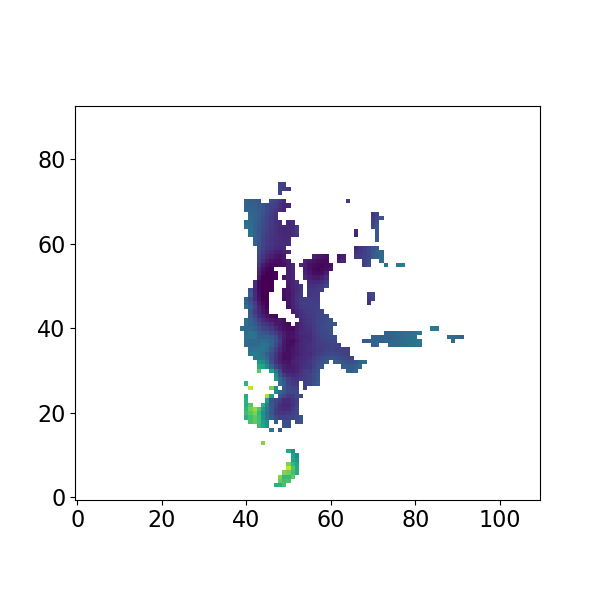

In [3]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul.info())



MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]



MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(BlankedMapTemperature.data,origin='lower',vmin = 20, vmax = 40)
plt.show()



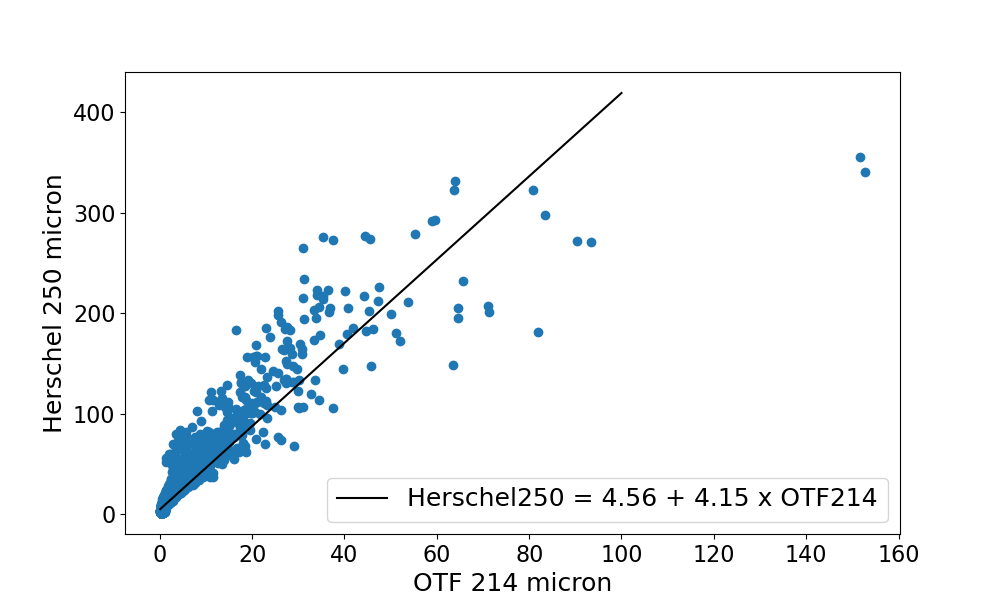

In [4]:
OTFdata214 = MapStokesI.data.flatten()
Herschel250 = MapHer250.data.flatten()

OTFbin = np.linspace(np.nanmin(OTFdata214),100,100)

selector = ~np.isnan(OTFdata214)
OTFdata214_fil = OTFdata214[selector]
Herschel250_fil = Herschel250[selector]

selector = ~np.isnan(Herschel250_fil)
OTFdata214_fil = OTFdata214_fil[selector]
Herschel250_fil = Herschel250_fil[selector]


# df_log = pd.DataFrame({'214':OTFdata214,'250':Herschel250})
# df_log = df_log.dropna()

param, param_cov = curve_fit(lin_fit, OTFdata214_fil, Herschel250_fil)
FitFunc = lin_fit(OTFbin,param[0],param[1])

fig = plt.subplots(figsize =(10, 6))
ax = plt.subplot(111)
ax.scatter(OTFdata214,Herschel250)
ax.plot(OTFbin,FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x OTF214'.format(param_a = param[0],param_b = param[1]))
ax.set_xlabel('OTF 214 micron')
ax.set_ylabel('Herschel 250 micron')
plt.legend()
plt.legend()
plt.show()

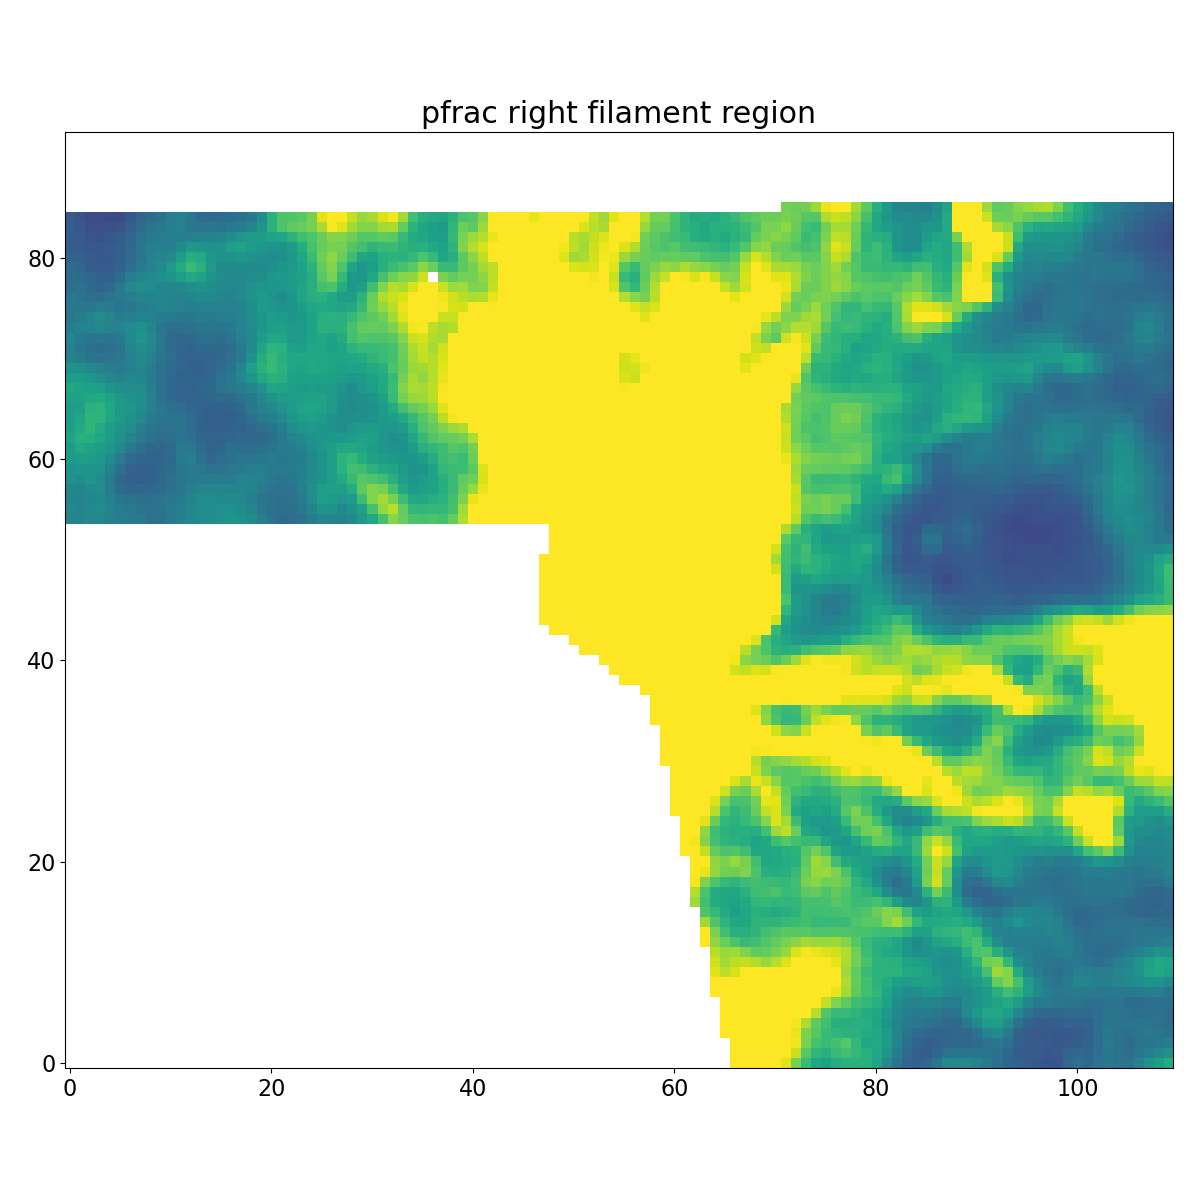

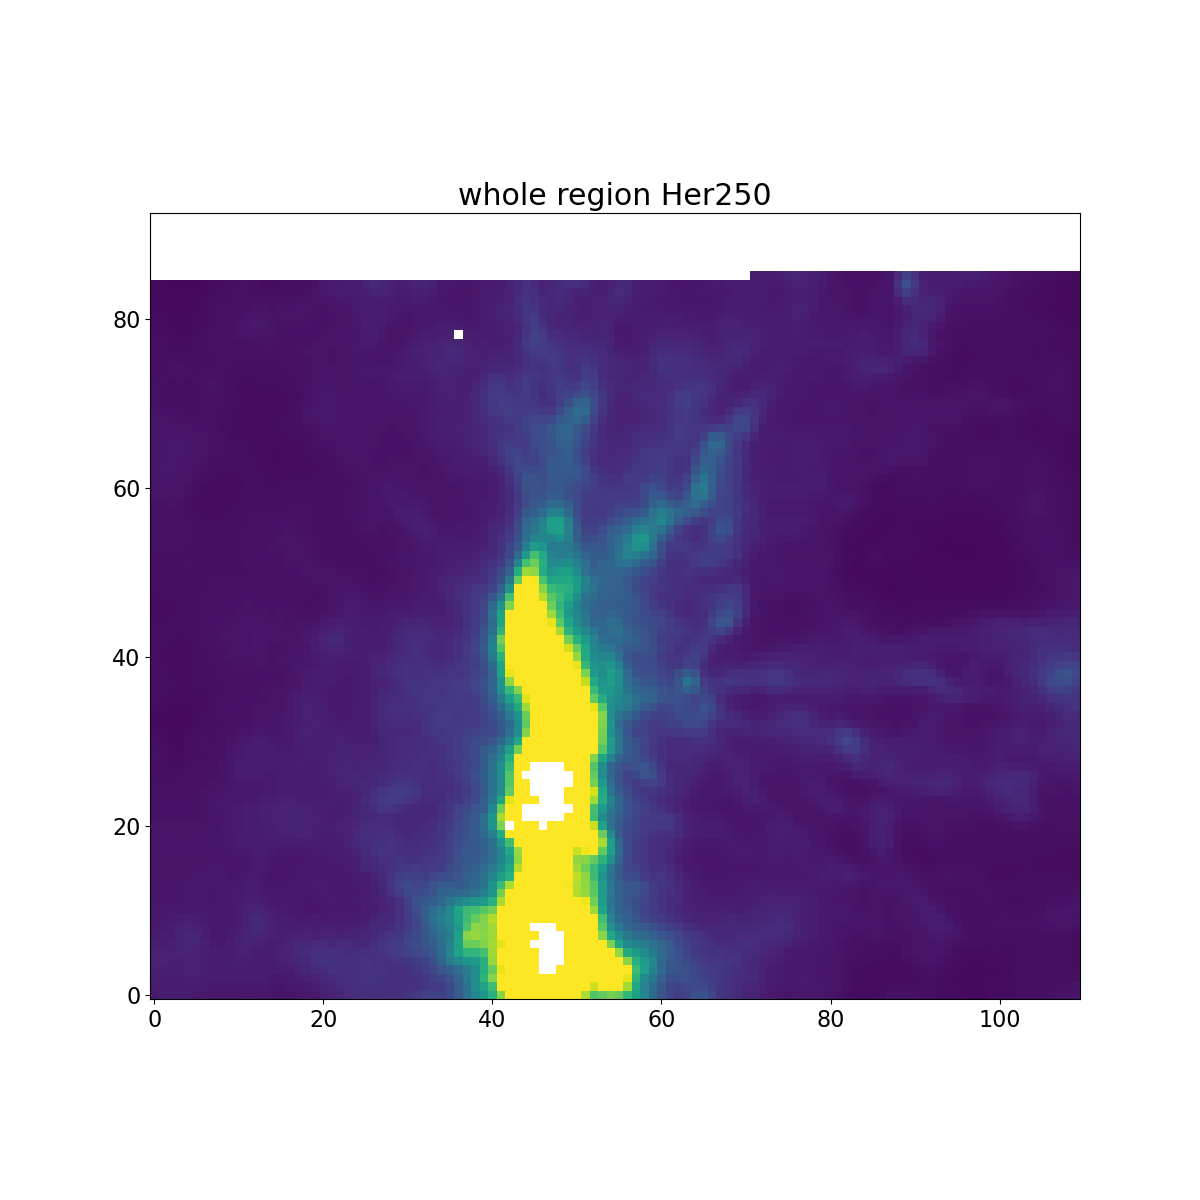

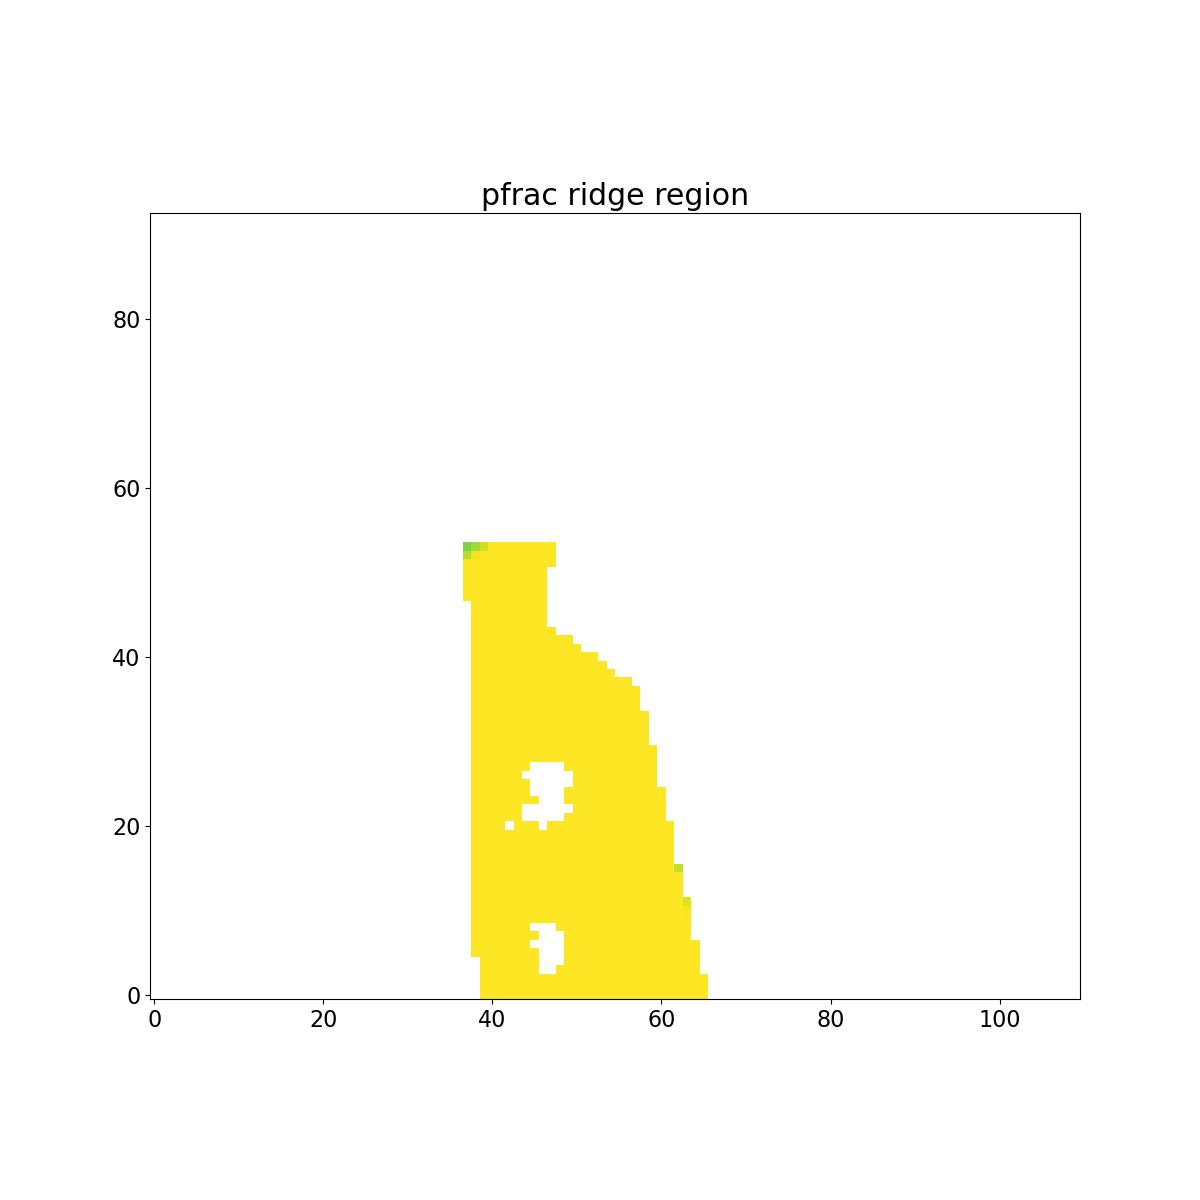

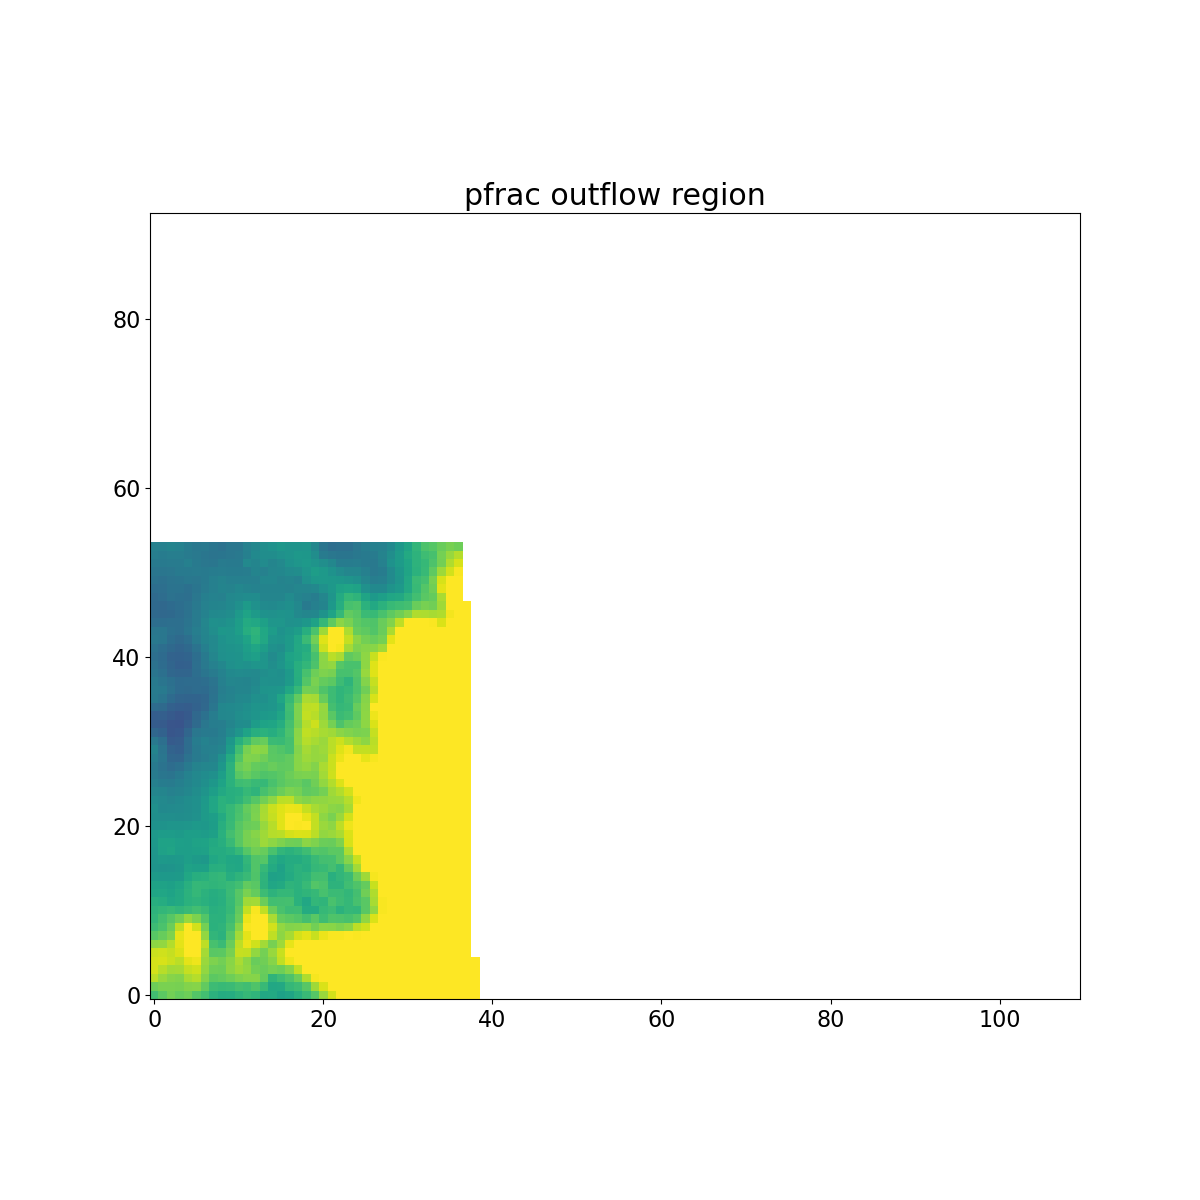

In [5]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

OTF_ridge_plus_fill_right= MapStokesI.copy()
HER_ridge_plus_fill_right = MapHer250.copy()

OTF_outflow = MapStokesI.copy()
HER_outflow = MapHer250.copy()



selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
OTF_ridge_plus_fill_right.data[selector] = np.nan
HER_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
OTF_outflow.data[selector] = np.nan
HER_outflow.data[selector] = np.nan



OTF_fil_right = OTF_ridge_plus_fill_right.copy()
HER_fil_right = HER_ridge_plus_fill_right.copy()


OTF_ridge = OTF_ridge_plus_fill_right.copy()
HER_ridge = HER_ridge_plus_fill_right.copy()



selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
OTF_ridge.data[selector] = np.nan
HER_ridge.data[selector] = np.nan


selector = ~selector
OTF_fil_right.data[selector] = np.nan
HER_fil_right.data[selector] = np.nan


# fig = plt.subplots(figsize =(12, 12))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log10(MapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log10(OTF_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('intensity ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log10(OTF_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('intensity outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log10(OTF_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('intensity right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(12, 12))
# ax1 = plt.subplot(111)
# ax1.imshow(np.log10(MapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# fig = plt.subplots(figsize =(12, 12))
# ax2 = plt.subplot(111)
# ax2.imshow(np.log10(OTF_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('intensity ridge region')
# fig = plt.subplots(figsize =(12, 12))
# ax3 = plt.subplot(111)
# ax3.imshow(np.log10(OTF_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('intensity outflow region')
# fig = plt.subplots(figsize =(12, 12))
# ax4 = plt.subplot(111)
# ax4.imshow(np.log10(OTF_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('intensity right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(MapHer250.data,origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region pfrac')
# ax2 = plt.subplot(222)
# ax2.imshow(HER_ridge.data,origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('pfrac ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(HER_outflow.data,origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('pfrac outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(HER_fil_right.data,origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('pfrac right filament region')
# plt.tight_layout()
# plt.show()

fig = plt.subplots(figsize =(12, 12))
ax1 = plt.subplot(111)
ax1.imshow(MapHer250.data,origin='lower',vmin=0,vmax = 50)
ax1.set_title('whole region Her250')
fig = plt.subplots(figsize =(12, 12))
ax2 = plt.subplot(111)
ax2.imshow(HER_ridge.data,origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('pfrac ridge region')
fig = plt.subplots(figsize =(12, 12))
ax3 = plt.subplot(111)
ax3.imshow(HER_outflow.data,origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('pfrac outflow region')
fig = plt.subplots(figsize =(12, 12))
ax4 = plt.subplot(111)
ax4.imshow(HER_fil_right.data,origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('pfrac right filament region')
plt.tight_layout()
plt.show()



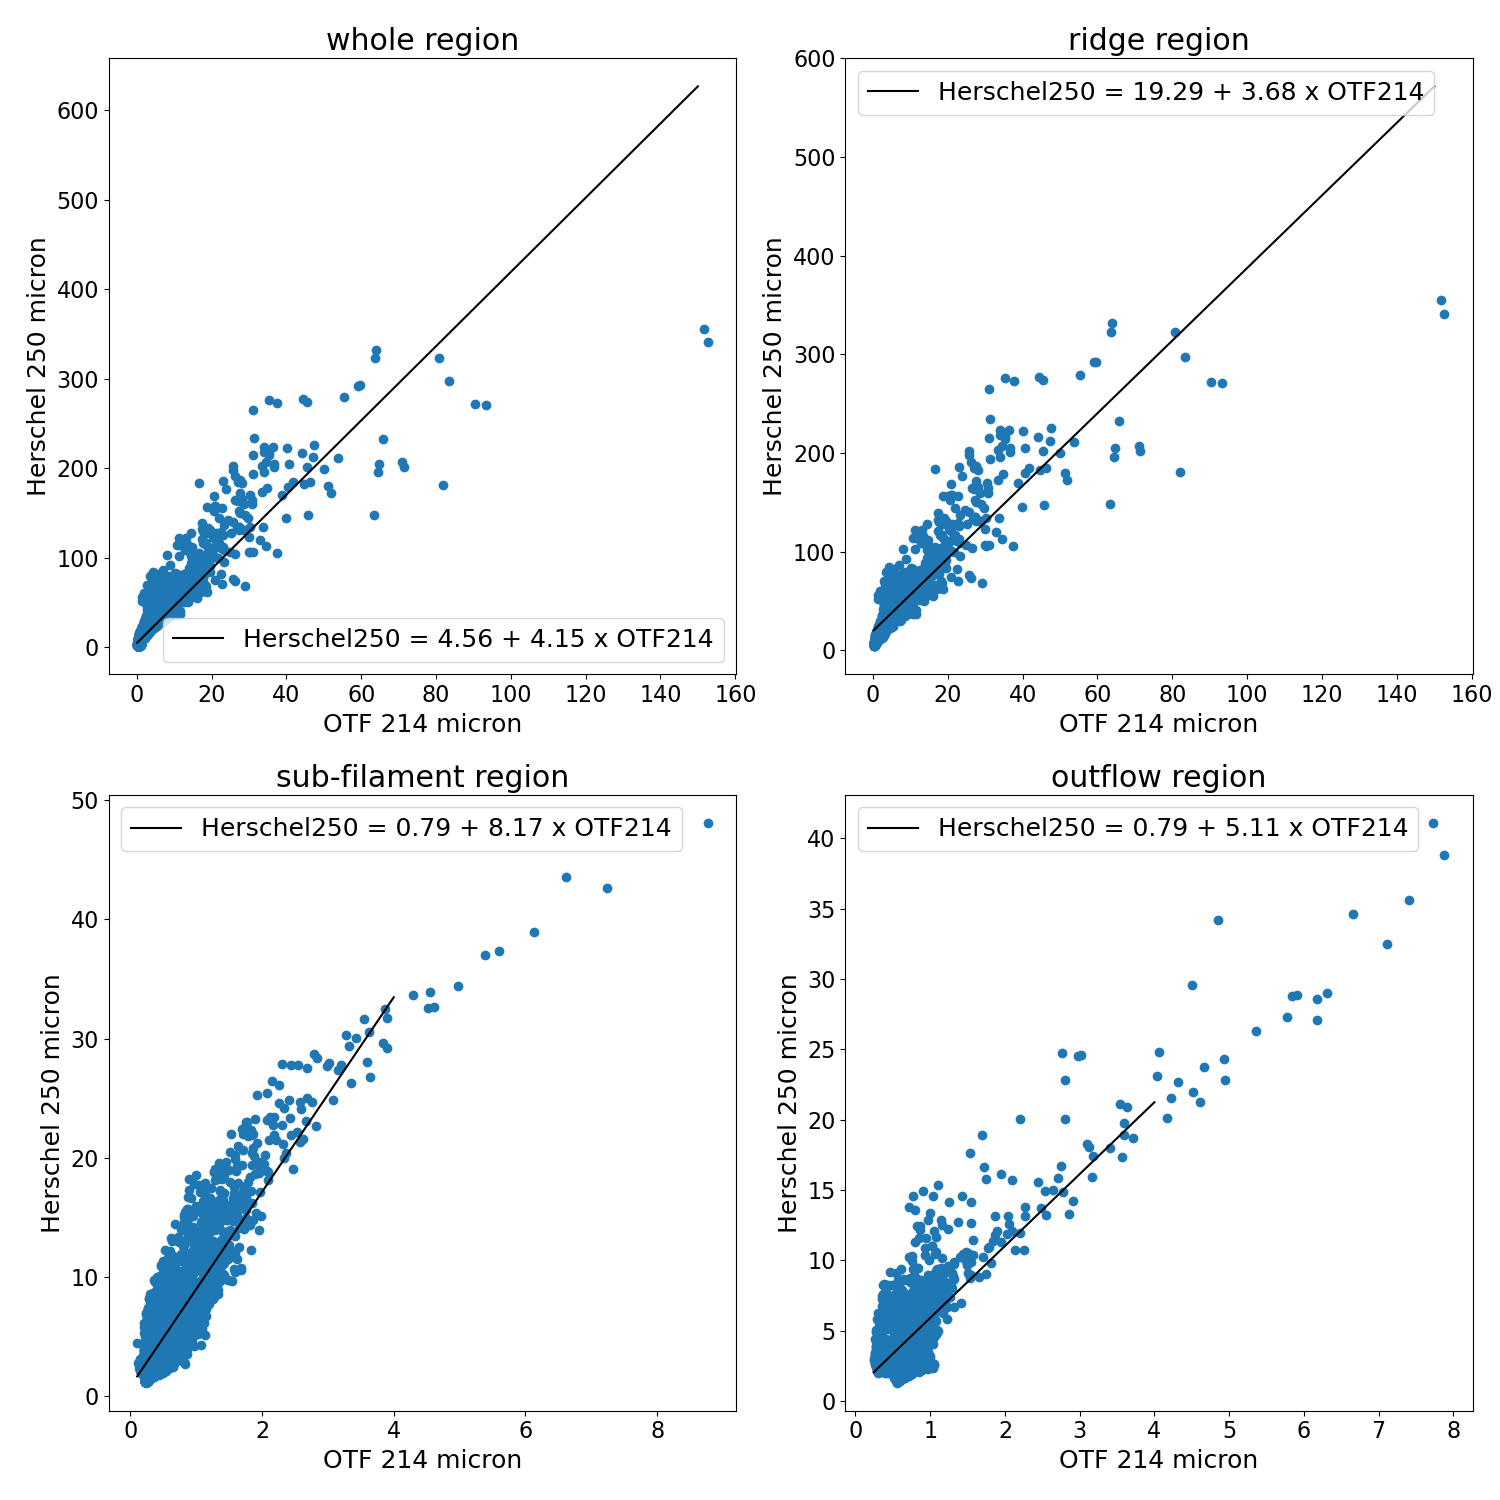

In [6]:
OTFdata215 = MapStokesI.data.flatten()
OTF_ridge_array = OTF_ridge.data.flatten()
OTF_outflow_array = OTF_outflow.data.flatten() 
OTF_fil_right_array =OTF_fil_right.data.flatten()

Herschel250 = MapHer250.data.flatten()
HER_ridge_array = HER_ridge.data.flatten()
HER_outflow_aray = HER_outflow.data.flatten()
HER_fil_right_array=HER_fil_right.data.flatten()


OTFdata214_fil,Herschel250_fil = remove_nan(OTFdata215,Herschel250)
w_param, w_param_cov = curve_fit(lin_fit, OTFdata214_fil, Herschel250_fil)
w_bin = np.linspace(np.nanmin(OTFdata214),150,100)
w_FitFunc = lin_fit(w_bin,w_param[0],w_param[1])

OTF_ridge_array_fil,HER_ridge_array_fil = remove_nan(OTF_ridge_array,HER_ridge_array)
r_param, r_param_cov = curve_fit(lin_fit, OTF_ridge_array_fil, HER_ridge_array_fil)
r_bin = np.linspace(np.nanmin(OTF_ridge_array_fil),150,100)
r_FitFunc = lin_fit(r_bin,r_param[0],r_param[1])

OTF_outflow_array_fil,HER_outflow_aray_fil = remove_nan(OTF_outflow_array,HER_outflow_aray)
o_param, o_param_cov = curve_fit(lin_fit, OTF_outflow_array_fil, HER_outflow_aray_fil)
o_bin = np.linspace(np.nanmin(OTF_outflow_array_fil),4,100)
o_FitFunc = lin_fit(o_bin,o_param[0],o_param[1])

OTF_fil_right_array_fil,HER_fil_right_array_fil = remove_nan(OTF_fil_right_array,HER_fil_right_array)
s_param, s_param_cov = curve_fit(lin_fit, OTF_fil_right_array_fil, HER_fil_right_array_fil)
s_bin = np.linspace(np.nanmin(OTF_fil_right_array_fil),4,100)
s_FitFunc = lin_fit(s_bin,s_param[0],s_param[1])


fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.scatter(OTFdata215,Herschel250)
ax1.plot(w_bin,w_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x OTF214'.format(param_a = w_param[0],param_b = w_param[1]))
ax1.set_xlabel('OTF 214 micron')
ax1.set_ylabel('Herschel 250 micron')
ax1.set_title('whole region')
ax1.legend()

ax2 = plt.subplot(222)
ax2.scatter(OTF_ridge_array,HER_ridge_array)
ax2.plot(r_bin,r_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x OTF214'.format(param_a = r_param[0],param_b = r_param[1]))
ax2.set_xlabel('OTF 214 micron')
ax2.set_ylabel('Herschel 250 micron')
ax2.set_title('ridge region')
ax2.legend()

ax3 = plt.subplot(223)
ax3.scatter(OTF_fil_right_array,HER_fil_right_array)
ax3.plot(s_bin,s_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x OTF214'.format(param_a = s_param[0],param_b = s_param[1]))
ax3.set_xlabel('OTF 214 micron')
ax3.set_ylabel('Herschel 250 micron')
ax3.set_title('sub-filament region')
ax3.legend()

ax4 = plt.subplot(224)
ax4.scatter(OTF_outflow_array,HER_outflow_aray)
ax4.plot(o_bin,o_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x OTF214'.format(param_a = o_param[0],param_b = o_param[1]))
ax4.set_xlabel('OTF 214 micron')
ax4.set_ylabel('Herschel 250 micron')
ax4.set_title('outflow region')
ax4.legend()
plt.tight_layout()
plt.show()